In [53]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import importlib
import subprocess

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

import ATARI.utils.io.hdf5 as h5io

from copy import copy
from ATARI.theory.resonance_statistics import make_res_par_avg


In [54]:
%matplotlib widget

In [63]:
# Functions for setting up feature bank

def get_parameter_grid(energy_grid, res_par_avg, num_Er, option=0):

    # allow Elambda to be just outside of the window
    max_Elam = max(energy_grid) + res_par_avg['Gt99']/10e3
    min_Elam = min(energy_grid) - res_par_avg['Gt99']/10e3

    if option == 1:
        Gn = np.repeat(res_par_avg["Gn01"], num_Er)
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
    else:
        Gn = np.repeat(res_par_avg["<Gn>"], num_Er)
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
        
    Er = np.linspace(              min_Elam,              max_Elam,                num_Er)
    
    return Er, Gg, Gn

def get_resonance_ladder(Er, Gg, Gn1, varyE=1, varyGg=1, varyGn1=1):
    return pd.DataFrame({"E":Er, "Gg":Gg, "Gn1":Gn1, "varyE":np.ones(len(Er))*varyE, "varyGg":np.ones(len(Er))*varyGg, "varyGn1":np.ones(len(Er))*varyGn1 ,"J_ID":np.ones(len(Er))})

# def get_resonance_ladder_df(resonance_ladder_array):

def plot_trans(exp_pw, T1):
    
    fig = figure()
    # plot(exp_pw.E, exp_pw.theo_trans, ms=1, color='g')
    # plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, 'r', alpha=0.2, lw=3)
    # plot(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.theo_trans_bayes, 'b-')
    plot(T1.E, T1.theo_trans, 'b')
    errorbar(exp_pw.E, exp_pw.exp, yerr=exp_pw.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    ylim([-.1, 1])
    return fig


def plot_trans_cap(trans, cap, T1=None,C1=None, plot_true=False):

    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)
    axes[0].errorbar(trans.E, trans.exp, yerr=trans.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    axes[1].errorbar(cap.E, cap.exp, yerr=cap.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    if C1 is not None and T1 is not None:
        axes[0].plot(T1.E, T1.theo_trans, 'b')
        axes[1].plot(C1.E, C1.theo_xs, 'b')
        if plot_true:
            axes[0].plot(trans.E, trans.true, 'g')
            axes[1].plot(cap.E, cap.true, 'g')
    else:
        axes[0].plot(trans.E, trans.true, 'g')
        axes[1].plot(cap.E, cap.true, 'g')
        

    axes[0].set_ylabel("T")
    axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$\sigma_{\gamma}$ (barns)')
    axes[1].set_ylim(bottom=5e-4)

    # legend()
    fig.supxlabel('Energy (eV)')
    fig.tight_layout()
    return fig


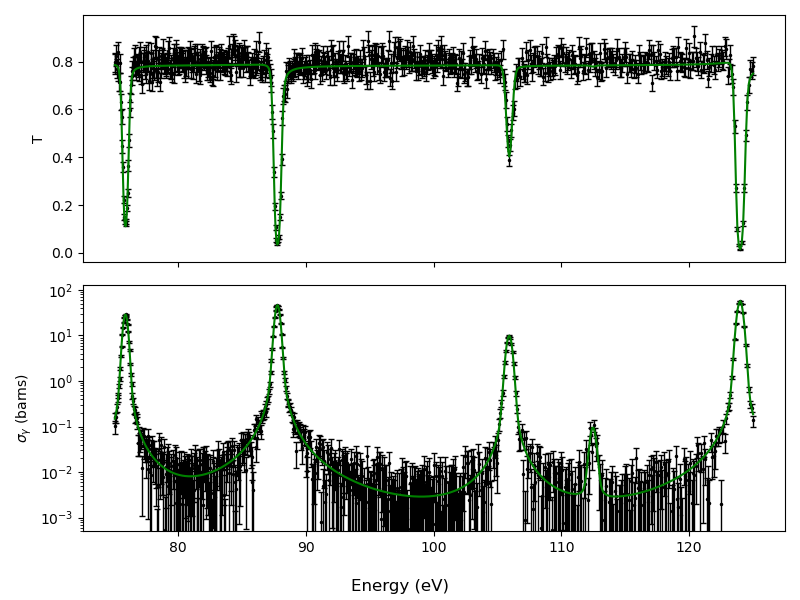

In [64]:
case_file = '/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/data.hdf5'  # if using hdf5

isample = 22

dataset_titles = ["trans1", "cap1"]
datasets = []
for dt in dataset_titles:
    exp_pw, exp_cov = h5io.read_pw_exp(case_file, isample, title=dt)
    datasets.append(exp_pw)

theo_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

trans = datasets[0]
cap = datasets[1]

fig = plot_trans_cap(trans, cap, T1=None, C1=None)

In [65]:
Gg_DOF = 10
spin_groups = [ (3.0,1,0) ]
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= 0.658, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1 
average_parameters = {'3.0':res_par_avg}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

num_Er = 100
Er, Gg, Gn = get_parameter_grid(exp_pw.E, res_par_avg, num_Er, option=1)

initial_reslad = get_resonance_ladder(Er, Gg, Gn, varyE=0, varyGg=0, varyGn1=1)
# initial_reslad

In [66]:
# columns=['E', 'Gg', 'Gn1', 'Gn2', 'Gn3', 'varyE', 'varyGg', 'varyGn1', 'varyGn2', 'varyGn3', 'J_ID']
# importlib.reload(sammy_functions) 
# sammy_functions.write_sampar(initial_reslad, Ta_pair, 0.1, "./test")

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'XCT',
    reaction = 'transmission',
    solve_bayes = False,
    inptemplate = "allexptot_1sg.inp",
    inpname = "sammy.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR_TC_vGn1',
    keep_runDIR = True,
    shell = 'zsh'
    )


# sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)

# sammyRTO_bayes = copy(sammyRTO)
# sammyRTO_bayes.solve_bayes = True
# sammyRTO_bayes.recursive = True
# sammyRTO_bayes.recursive_opt = {"threshold":0.01,  "iterations": 10, "print":True}      

# # sammyOUT_bayes = sammy_functions.run_sammy(sammyINP, sammyRTO_bayes)

def run_YW_scheme(sammyINPyw, sammyRTO, resonance_ladder):
    
    sammyINPyw.resonance_ladder = resonance_ladder
    sammy_functions.setup_YW_scheme(sammyRTO, sammyINPyw)

    os.system(f"chmod +x {os.path.join(sammyRTO.sammy_runDIR, f'iterate.{sammyRTO.shell}')}")
    os.system(f"chmod +x {os.path.join(sammyRTO.sammy_runDIR, f'run.{sammyRTO.shell}')}")

    result = subprocess.check_output(os.path.join(sammyRTO.sammy_runDIR, f'run.{sammyRTO.shell}'), shell=True, text=True)
    ifinal = int(result.splitlines()[-1]) -1

    par = sammy_functions.readpar(os.path.join(sammyRTO.sammy_runDIR,f"results/step{ifinal}.par"))
    lsts = []
    for dt in sammyINPyw.dataset_titles:
        lsts.append(sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/{dt}_step{ifinal}.lst")) )

    return par, lsts


In [75]:
res_par_avg["Gn01"]


0.00010336381050458381

In [79]:
importlib.reload(sammy_functions)
importlib.reload(sammy_classes)

sammyRTO_ls = copy(sammyRTO)

# sammyRTO_ls.sammy_runDIR = "./SAMMY_runDIR_ls"
sammyRTO_ls.keep_runDIR = True
iterations = 2
steps = 200
threshold = 0.01

# datasets = [exp_pw]
# dataset_titles = ["trans1"]
# reactions = ["transmission"]
# templates = ["/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/sammy_templates/allexptot_1sg.inp"]

reactions = ["transmission", "capture"]
templates = ["allexptot_1sg.inp", "allexpcap_1sg.inp"]

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = initial_reslad,

    datasets= datasets,
    dataset_titles= dataset_titles,
    reactions= reactions,
    templates= templates,
    
    steps = 200,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = 1e-4,

    LS = False,
    initial_parameter_uncertainty = 0.01,

    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)



# par, lsts = run_YW_scheme(sammyINPyw, sammyRTO_ls, initial_reslad)
par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

# sammyINPyw.resonance_ladder = initial_reslad
# sammy_functions.setup_YW_scheme(sammyRTO_ls, sammyINPyw)


# os.system(f"chmod +x {os.path.join(sammyRTO_ls.sammy_runDIR, f'iterate.{sammyRTO_ls.shell}')}")
# os.system(f"chmod +x {os.path.join(sammyRTO_ls.sammy_runDIR, f'run.{sammyRTO_ls.shell}')}")

rm: chi2.txt: No such file or directory


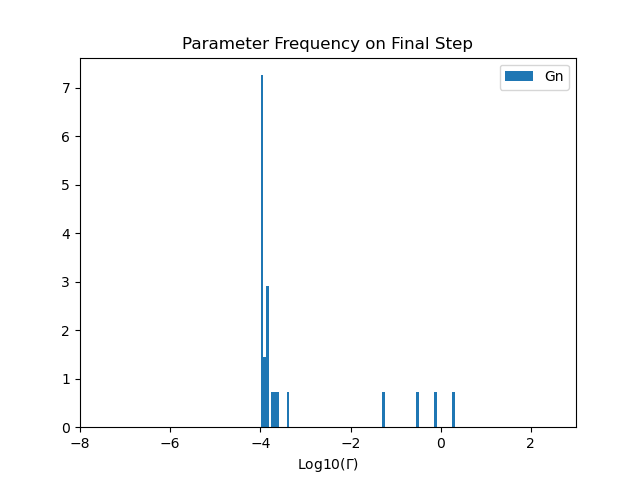

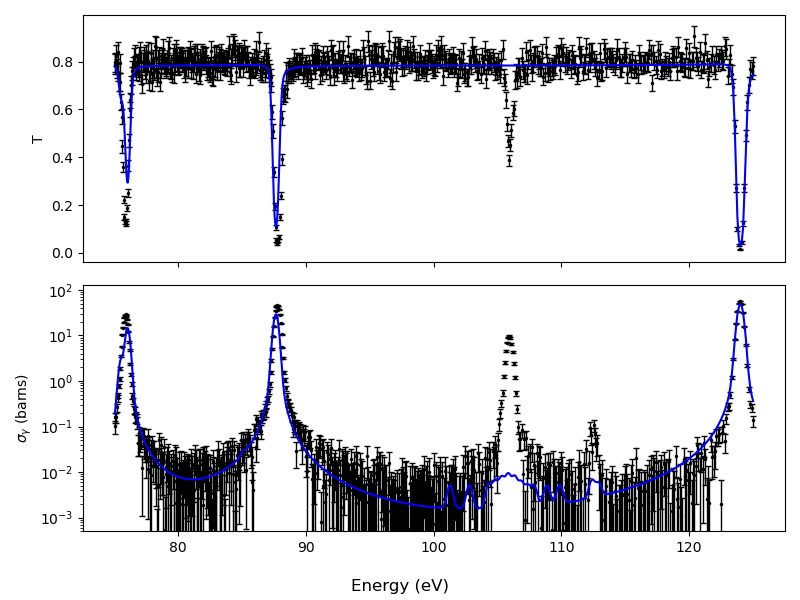

In [76]:
P1 = par
T1, C1 = lsts

figure()
bins = hist(np.log10(P1.Gn1), bins=75, density=True, label="Gn")
# bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
legend()
xlim([-8, 3])
# savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/case_2a.png")

fig = plot_trans_cap(trans, cap, T1=T1, C1=C1)
# fig = plot_trans(exp_pw, T1)

In [77]:
P2 = copy(P1)

P2 = P2[P2.Gn1 > 1e-4]
P2["varyGg"] = np.ones(len(P2))
P2["varyE"] = np.ones(len(P2))

sammyRTO_ls.sammy_runDIR= "SAMMY_runDIR_TC_vGn1_E"
# sammyINPyw.initial_parameter_uncertainty = 0.001
sammyINPyw.step_threshold = 0.001
par, lsts = run_YW_scheme(sammyINPyw, sammyRTO_ls, P2)


rm: chi2.txt: No such file or directory


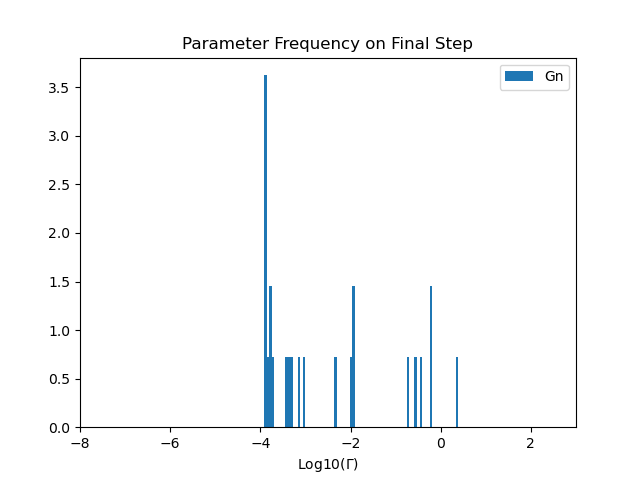

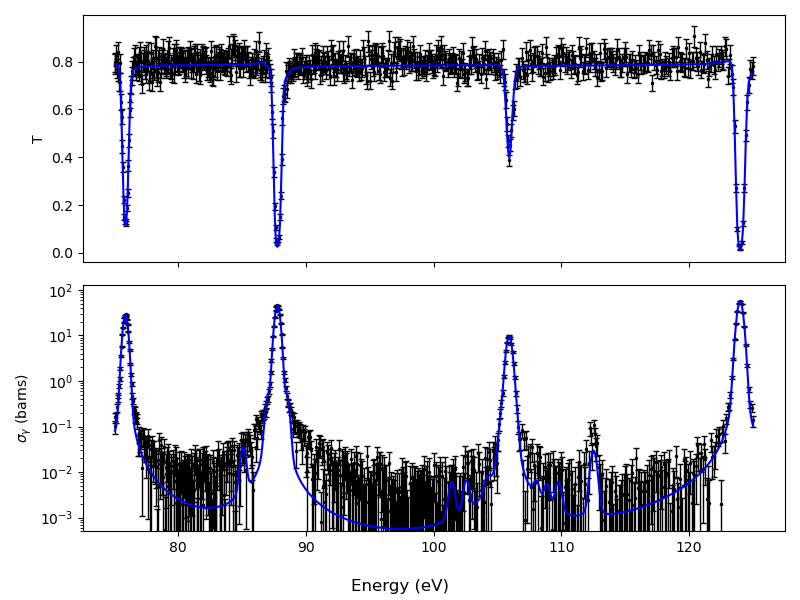

In [78]:
P2 = par
T2, C2 = lsts


figure()
bins = hist(np.log10(P2.Gn1), bins=75, density=True, label="Gn")
# bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
legend()
xlim([-8, 3])

fig = plot_trans_cap(trans, cap, T1=T2, C1=C2)

In [99]:
P3 = copy(P2)

P3 = P3[P3.Gn1 > 1e-5]
P3["varyGg"] = np.ones(len(P3))
P3["varyE"] = np.ones(len(P3))

sammyRTO_ls.sammy_runDIR= "SAMMY_runDIR_TC_vall"
sammyINPyw.step_threshold = 0.001
sammyINPyw.initial_parameter_uncertainty = 0.0
par, lsts = run_YW_scheme(sammyINPyw, sammyRTO_ls, P3)

rm: chi2.txt: No such file or directory


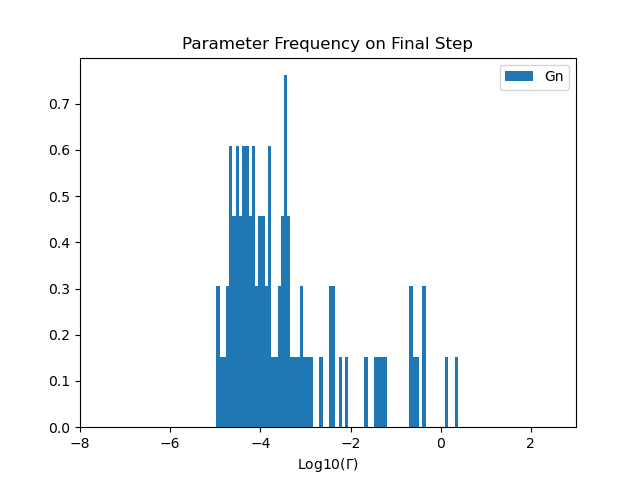

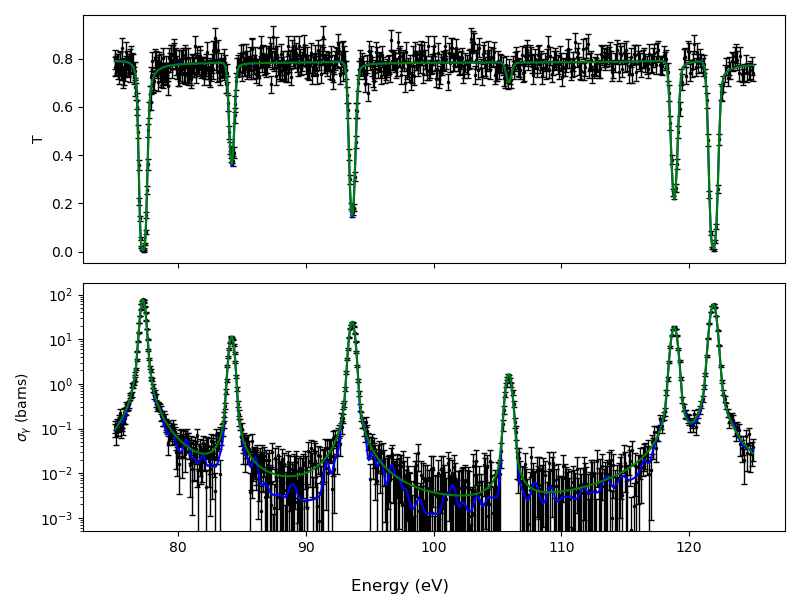

In [101]:
P3 = par
T3, C3 = lsts


figure()
bins = hist(np.log10(P3.Gn1), bins=75, density=True, label="Gn")
# bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
legend()
xlim([-8, 3])

fig = plot_trans_cap(trans, cap, T1=T3, C1=C3,plot_true=True)

### Final fit with ls

In [111]:
sammyRTO_ls.sammy_runDIR= "SAMMY_runDIR_TC_vGn1_E"
P3 = sammy_functions.readpar(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/step{ifinal2}.par"))

P3 = P3[P3.Gn1 > 1e-3]
P3["varyGg"] = np.ones(len(P3))
P3["varyE"] = np.ones(len(P3))

sammyRTO_ls.sammy_runDIR= "SAMMY_runDIR_TC_vGn1_Gg"
sammyINP.resonance_ladder = P3
# sammyINP.resonance_ladder = theo_par
sammy_functions.setup_YW_scheme(sammyRTO_ls, sammyINP, datasets, dataset_titles, reactions, templates, 
                                                                                steps=steps,
                                                                                iterations=iterations,
                                                                                threshold=threshold)

os.system(f"chmod +x {os.path.join(sammyRTO_ls.sammy_runDIR, 'iterate.zsh')}")
os.system(f"chmod +x {os.path.join(sammyRTO_ls.sammy_runDIR, 'run.zsh')}")

print(len(P1))
print(len(P2))
print(len(P3))
result3 = subprocess.check_output(os.path.join(sammyRTO_ls.sammy_runDIR, 'run.zsh'), shell=True, text=True)
print(result3)

26
11
11


rm: chi2.txt: No such file or directory



Iterating until convergence
chi2 values
step  trans1 cap1 sum
0 0.776773 3.56912 4.345893
1 0.772965 3.28415 4.057115
2 0.768785 3.05233 3.821115
3 0.763915 2.85622 3.620135
4 0.759128 2.71757 3.476698
Loop terminated after 5 iterations because improvement below threshold.
5



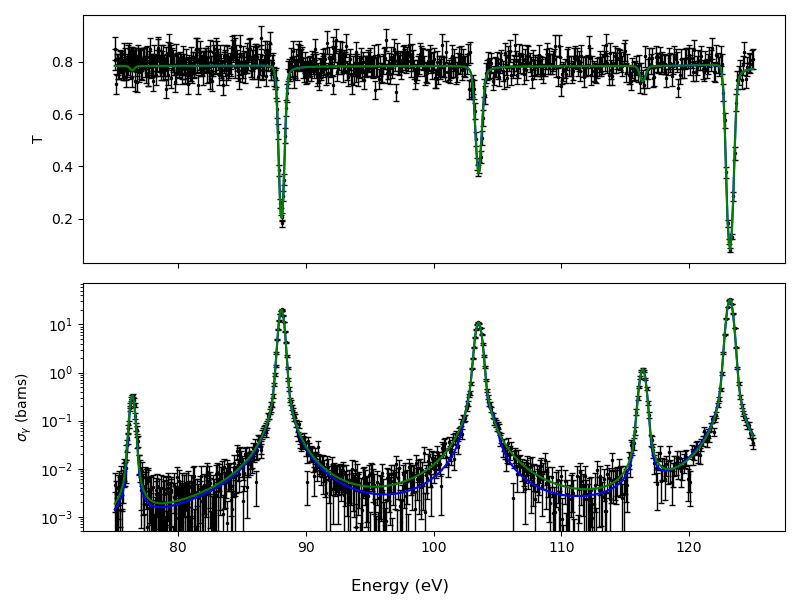

In [112]:
# ifinal2 = 200
ifinal3 = int(result3.splitlines()[-1]) - 1

P3 = sammy_functions.readpar(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/step{ifinal3}.par"))
T3 = sammy_functions.readlst(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/trans1_step{ifinal3}.lst"))

C3 = sammy_functions.readlst(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/cap1_step{ifinal3}.lst"))

fig = plot_trans_cap(exp_pw, cap_pw, T1=T3, C1=C3, plot_true=True)


In [96]:
# figure()
# bins = hist(np.log10(P3.Gn1), bins=75, density=True, label="Gn")
# # bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
# xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
# legend()
# xlim([-8, 3])

In [97]:
# sammyRTO_ls.sammy_runDIR= "/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR"
# sammyRTO_ls.keep_runDIR= True
# P4 = sammy_functions.readpar("/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_0_iE60_step2/results/step6.par")

# # P4 = P4[P4.Gn1 > 1e-3]
# # P4["varyGg"] = np.ones(len(P4))
# # P4["varyE"] = np.ones(len(P4))

# sammyINP.resonance_ladder = P4
# sammy_functions.setup_YW_scheme(sammyRTO_ls, sammyINP, datasets, dataset_titles, reactions, templates, 
#                                                                                 steps=steps,
#                                                                                 iterations=iterations,
#                                                                                 threshold=0.001)

# os.system(f"chmod +x {os.path.join(sammyRTO_ls.sammy_runDIR, 'iterate.zsh')}")
# os.system(f"chmod +x {os.path.join(sammyRTO_ls.sammy_runDIR, 'run.zsh')}")

# result3 = subprocess.check_output(os.path.join(sammyRTO_ls.sammy_runDIR, 'run.zsh'), shell=True, text=True)

In [98]:
# print(result3)

In [99]:
# # ifinal2 = 200
# ifinal3 = int(result3.splitlines()[-1]) - 1

# P4 = sammy_functions.readpar(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/step{ifinal3}.par"))
# T4 = sammy_functions.readlst(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/trans1_step{ifinal3}.lst"))

# C4 = sammy_functions.readlst(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/cap1_step{ifinal3}.lst"))

# fig = plot_trans_cap(exp_pw, cap_pw, T1=T4, C1=C4, plot_true=True)

### Final fit with bayes

In [100]:
# importlib.reload(sammy_functions)

sammyRTO_ls.sammy_runDIR= "SAMMY_runDIR_TC_vGn1_E"
P3 = sammy_functions.readpar(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/step{ifinal2}.par"))

P3 = P3[P3.Gn1 > 1e-2]
P3["varyGg"] = np.ones(len(P3))
P3["varyE"] = np.ones(len(P3))

sammyRTO_ls.sammy_runDIR= "SAMMY_runDIR_trans"
sammyINP.resonance_ladder = P3

# sammyRTO_bayes = copy(sammyRTO)
# sammyRTO_bayes.sammy_runDIR = "/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_trans"
# sammyINP.resonance_ladder = sammy_functions.readpar("/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_0_iE60_step2/results/step6.par")
sammyINP.experimental_data = exp_pw
sammyRTO.inptemplate = 'allexptot_1sg.inp'
sammyRTO.reaction = 'transmission'
sammyRTO.solve_bayes = True
sammyINP.initial_parameter_uncertainty = 0.001
sammyRTO.recursive = False
sammyRTO.keep_runDIR = True
sammyRTO.recursive_opt = {"threshold":0.01,  "iterations": 10, "print":True}      

sammyOUT_bayes = sammy_functions.run_sammy(sammyINP, sammyRTO)

In [101]:
sammyOUT_bayes.pw

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,75.029778,3.177031,0.747539,3.616113,3.616108,0.807832,0.040563,0.784366,0.784366
1,75.082129,2.405336,0.762342,3.616076,3.616071,0.850810,0.043567,0.784368,0.784368
2,75.134535,4.997320,0.781305,3.616038,3.616033,0.714859,0.037516,0.784370,0.784370
3,75.186995,3.544773,0.758338,3.616000,3.615995,0.788122,0.040145,0.784372,0.784372
4,75.239510,3.810667,0.773676,3.615961,3.615957,0.774171,0.040232,0.784374,0.784374
...,...,...,...,...,...,...,...,...,...
642,124.551153,3.656376,0.704835,3.922928,3.919303,0.782236,0.037034,0.768367,0.768554
643,124.663138,3.385497,0.694687,3.892059,3.889091,0.796599,0.037171,0.769962,0.770116
644,124.775274,3.445479,0.695840,3.866965,3.864492,0.793396,0.037083,0.771261,0.771389
645,124.887561,3.165333,0.692942,3.846183,3.844094,0.808467,0.037630,0.772338,0.772447


In [102]:

sammyRTO.sammy_runDIR = "SAMMY_runDIR_cap"
sammyINP.resonance_ladder = sammyOUT_bayes.par_post #sammy_functions.readpar("/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_0_iE60_step2/results/step6.par")
sammyINP.experimental_data = cap_pw #sammy_functions.readlst("/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_0_iE60_step2/cap1.dat")
sammyRTO.reaction = 'capture'
sammyRTO.inptemplate = 'allexpcap_1sg.inp'

sammyRTO.recursive = False
sammyRTO.keep_runDIR = True
sammyRTO.recursive_opt = {"threshold":0.01,  "iterations": 10, "print":True}      

sammyOUT_bayes_cap = sammy_functions.run_sammy(sammyINP, sammyRTO)


In [103]:
sammyOUT_bayes.par

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,varyGn2,varyGn3,Gn2,Gn3
2,88.082052,64.0,0.485764,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,103.417134,64.0,0.239546,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
5,103.662918,64.0,0.129027,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
8,116.387084,64.0,0.038133,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
9,123.168950,64.0,1.129884,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
10,123.239833,64.0,0.139935,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


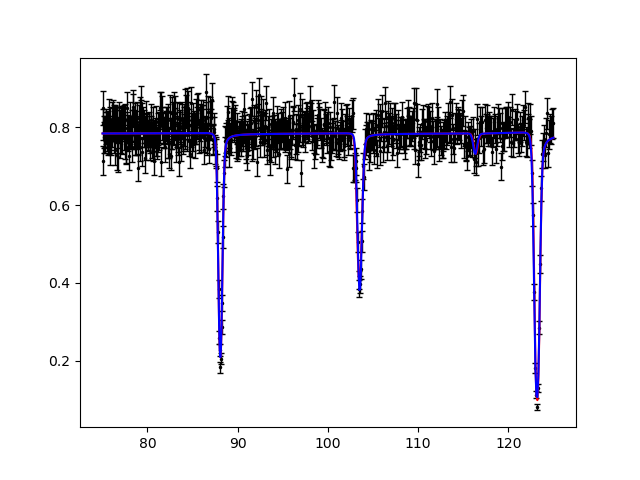

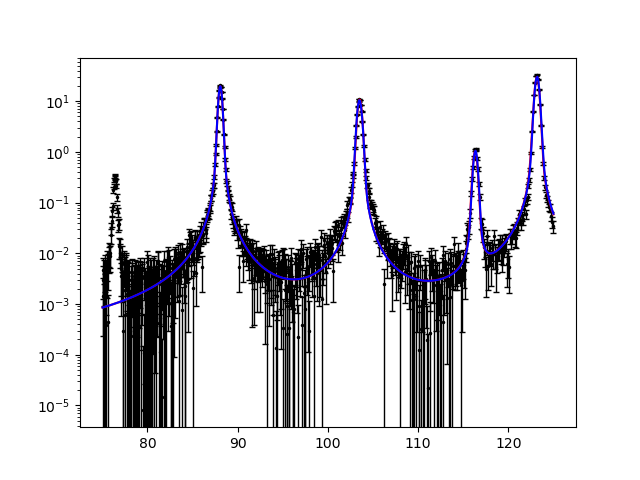

In [104]:
figure()

plot(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.theo_trans, 'r')
# plot(T4.E, T4.theo_trans, 'r')
plot(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.theo_trans_bayes, 'b')
errorbar(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.exp_trans, yerr=sammyOUT_bayes.pw.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

figure()

plot(sammyOUT_bayes_cap.pw.E, sammyOUT_bayes_cap.pw.theo_xs, 'r')
# plot(T4.E, T4.theo_trans, 'r')
plot(sammyOUT_bayes_cap.pw.E, sammyOUT_bayes_cap.pw.theo_xs_bayes, 'b')
errorbar(sammyOUT_bayes_cap.pw.E, sammyOUT_bayes_cap.pw.exp_xs, yerr=sammyOUT_bayes_cap.pw.exp_xs_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

yscale('log')

In [105]:
# import imageio

# for i in range(1,ifinal):
    
#     # C1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/cap1_step{i}.lst"))
#     T1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/trans1_step{i}.lst"))

#     # fig = plot_trans_cap(exp_pw, cap_pw, T1=T1, C1=C1)
#     fig = plot_trans(exp_pw, T1)
#     fig.savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/figures/case2a_{i}.png")
#     close()

In [106]:

# images = []
# for i in range(1,ifinal): #range(start_job,end_job):
#     images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/figures/case2a_{i}.png"))
# imageio.mimsave(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/case_2a.gif", images)



In [107]:
# os.system(os.path.join(sammyRTO.sammy_runDIR, 'run.zsh'))
